## Goals of Script

1. Automate the process of writing notes in a natural language format of each tract in a BLM Oil and Gas Lease Sale

2.  Creaete visualizaitons tract by tract of permitting, new production, and leasing activity within a given radius

3.  Create a predictive model to estimate the purchase price based on historical activity, production, permits, and commodity prices

### Pending Tasks

* Add functionality to create concatenated dataframes for lease tracts with multiple polygons - This will create separate filters for each polygons individual centroid and compile the data as 1 dataframe for visualization and analysis

* Separate large file into sub notebooks for handling cleaning, filtering, note creation, modeling, etc

* fix bug in note generation where leases with high variabliity in bonus price skews the summary (remove outliars)


In [4]:
import pandas as pd
import geopandas as gp
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import shapely
import math
import datetime as dt
import pdb

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
#had to add GDAL_DATA variable to system variables and set value to the folder of gdal in C:\Users\mishaun\AppData\Local\Continuum\anaconda3\Library\share\gdal on my work computer
'GDAL_DATA' in os.environ

False

# Reading in Data/Data Preparation for Automating Sale Notes

In [5]:
shapezipfile = ("zip://Data/BLM MT Sep 22, 2020 Shapefile.zip")
tractshp = gp.read_file(shapezipfile, encoding = "utf-8")

In [6]:
#this is shapefile downloaded from drillinginfo holding well information
prodshp = gp.read_file("zip://Data/production.ZIP")
permitshp = gp.read_file("zip://Data/permits.ZIP")

#reading in csv of leases - converting to a GeoDataFrame - initial coord system is epsg:4326
leases = pd.read_csv("Data/LeasesTable.CSV")
leasesgeo = gp.GeoDataFrame(leases, crs = {'init': 'epsg:4326'}, geometry=gp.points_from_xy(leases["Longitude (WGS84)"], leases["Latitude (WGS84)"]))

oldprod = gp.read_file("zip://data/oldProduction.zip")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
saleDate = pd.Timestamp(dt.date(2020, 9, 22))

### Trimming and Cleaning Data

In [8]:
leasesgeo.columns

Index(['State/Province', 'Effective Date', 'Record Date',
       'Expiration of Primary Term', 'Term (Months)', 'Grantor',
       'Grantee Alias', 'Royalty', 'Bonus', 'Area (Acres)', 'Section',
       'Township', 'Township Direction', 'Range', 'Range Direction',
       'Vol/Page', 'Record Number', 'Instrument Type', 'Instrument Date',
       'County/Parish', 'Options/Extensions', 'DI Basin', 'Ext. Bonus',
       'Ext. Term (Months)', 'Abstract', 'Block', 'BLM', 'State Lease',
       'Grantee', 'Max Depth', 'Majority Legal Assignee', 'DI Subplay',
       'Min Depth', 'Majority Assignment Effective Date', 'Latitude (WGS84)',
       'DI Play', 'Majority Legal Assignee Interest', 'Longitude (WGS84)',
       'Majority Assignment Vol/Page', 'geometry'],
      dtype='object')

In [12]:
try:
    leasesgeo.drop(columns = ['Instrument Type', 'Instrument Date','Options/Extensions', 'DI Basin', 'Ext. Bonus',
       'Ext. Term (Months)', 'Abstract', 'Block', 'BLM', 'State Lease',
       'Grantee', 'Grantor Address', 'Grantee Address', 'Max Depth',
       'Majority Legal Assignee', 'DI Subplay', 'Min Depth',
       'Majority Assignment Effective Date','Majority Legal Assignee Interest','Majority Assignment Vol/Page'], inplace = True)
except:
    print("column for drop was not available")

column for drop was not available


In [13]:
prodshp.columns

Index(['APIUWI', 'OpAlias', 'OpCompany', 'OpReported', 'OpTicker', 'LeaseName',
       'WellNo', 'EntityType', 'County', 'DIBasin',
       ...
       'PGC_Area', 'Latitude', 'Longitude', 'Last12Liq', 'Last12Gas',
       'Last12Wtr', 'EntityId', 'OtherNo', 'OpAliasID', 'geometry'],
      dtype='object', length=112)

In [14]:
prodshp.drop(columns = ['LatestWtr','CumWtr',
       'Prior12Liq', 'Prior12Gas', 'LastTestDt', 'Prior12Wtr', 'LastFlwPrs',
       'LastWHSIP', '2moGOR', 'LatestGOR', 'CumGOR', 'Lst12Yield', '2moYield',
       'LatestYld', 'PeakGas', 'PkGasMoNo', 'PeakLiq', 'PkLiqMoNo', 'PeakBOE',
       'PkBOEMoNo', 'PkMMCFGE', 'PkMMCFGMoN', 'TopPerf', 'BtmPerf', 'GasGrav',
       'OilGrav','CompDate', 'GasGather',
       'LiqGather', 'LeaseNo'], inplace = True)

In [15]:
permitshp.columns

Index(['API10UWI', 'WGID', 'PermitNo', 'Country', 'OFS_Reg', 'State', 'County',
       'DIBasin', 'DIPlay', 'DISubplay', 'District', 'OpAlias', 'OpCompany',
       'OpReported', 'OpTicker', 'LeaseName', 'WellNo', 'LeaseNo', 'Field',
       'Formation', 'PermitType', 'WellType', 'DrillType', 'PermDepth',
       'PermDUOM', 'TVD', 'TVD_UOM', 'PermStatus', 'WellStatus', 'FiledDate',
       'AprvdDate', 'AmendDate', 'CntctName', 'CntctPhone', 'OperAddrs',
       'OperCity', 'OperState', 'OperZip', 'OperCity30', 'OperCity50',
       'Section', 'Township', 'Range', 'Block', 'Survey', 'Abstract',
       'H2S_Area', 'Latitude', 'Longitude', 'Btm_Lat', 'Btm_Lon', 'ExpDate',
       'geometry'],
      dtype='object')

In [16]:
permitshp.drop(columns = ['OpReported', 'AmendDate', 'CntctName',
       'CntctPhone', 'OperAddrs', 'OperCity', 'OperState', 'OperZip',
       'OperCity30', 'Section', 'OperCity50', 'Township', 'Range', 'Block',
       'Survey', 'TVD_UOM', 'Abstract', 'WGID', 'H2S_Area','OFS_Reg', 'LeaseNo', 'PermDUOM',
       'PermitNo','OpCompany', 'OpTicker'], inplace=True)

In [17]:
oldprod.info()
oldprod.columns

dropcols = ['CumWtr', 'DISubplay', '1moLiq',
       '1moGas', '6moLiq', 'DIBasin', '6moGas', '6moBOE', '6moWater', 'DIPlay',
       'PracIP_Liq', 'PracIP_BOE', 'PracIP_Gas', 'PrcIPCFGED', 'LatestWtr',
       'Prior12Liq', 'Prior12Gas', 'LastTestDt', 'Prior12Wtr', 'LastFlwPrs',
       'LastWHSIP', '2moGOR', 'LatestGOR', 'CumGOR', 'Lst12Yield', '2moYield',
       'LatestYld', 'PeakGas', 'PkGasMoNo', 'PeakLiq', 'PkLiqMoNo', 'PeakBOE',
       'PkBOEMoNo', 'PkMMCFGE', 'PkMMCFGMoN', 'TopPerf', 'BtmPerf', 'GasGrav',
       'OilGrav', 'CompDate', 'WellCount', 'MaxActvWel', 'GasGather',
       'LiqGather', 'LeaseNo', 'PerfLength', 'TVD', 'Field', 'State',
       'District', 'GeoProvin','Country','OCS_Area', 'PGC_Area',
       'OpReported', 'Survey', 'EntityId', 'Last12Liq', 'Last12Gas',
       'Last12Wtr', 'OtherNo']

oldprod.drop(columns=dropcols, inplace = True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 23203 entries, 0 to 23202
Columns: 112 entries, APIUWI to geometry
dtypes: float64(68), geometry(1), int64(3), object(40)
memory usage: 19.8+ MB


Index(['APIUWI', 'OpAlias', 'OpCompany', 'OpReported', 'OpTicker', 'LeaseName',
       'WellNo', 'EntityType', 'County', 'DIBasin',
       ...
       'PGC_Area', 'Latitude', 'Longitude', 'Last12Liq', 'Last12Gas',
       'Last12Wtr', 'EntityId', 'OtherNo', 'OpAliasID', 'geometry'],
      dtype='object', length=112)

In [18]:
leasesgeo.info()
prodshp.info()
permitshp.info()
oldprod.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 32969 entries, 0 to 32968
Data columns (total 40 columns):
State/Province                        32969 non-null object
Effective Date                        25620 non-null object
Record Date                           32969 non-null object
Expiration of Primary Term            32969 non-null object
Term (Months)                         32969 non-null int64
Grantor                               32969 non-null object
Grantee Alias                         28589 non-null object
Royalty                               21971 non-null float64
Bonus                                 2562 non-null float64
Area (Acres)                          31935 non-null float64
Section                               32969 non-null float64
Township                              32969 non-null float64
Township Direction                    32969 non-null object
Range                                 32969 non-null float64
Range Direction                       3

### Converting geodataframes to same coord system - UTM system for creating buffers

In [19]:
def convertCRS(*args, crs_system = 26913):
    for i in args:
        print(i.crs)
        i.to_crs(epsg = crs_system, inplace = True)
        print("Converted to:")
        print(i.crs)
        print("\n")

In [20]:
def convertoDateTime(*dataframe):
    '''
    This function will take in arguments of a dataframe.
    It will then search each column name to see if there is a date in the name using the filter method
    The filtered list will then use the apply method to convert data in column to date time
    '''
    for df in dataframe:
        cols = list(filter(lambda x: 'date' in x.lower(), df.columns))

        for col in cols:
            df[col] = df[col].apply(lambda x: pd.to_datetime(x))

In [21]:
convertCRS(prodshp, permitshp, leasesgeo, tractshp, oldprod)

prodshp.crs
permitshp.crs
leasesgeo.crs
oldprod.crs

{'init': 'epsg:4326'}
Converted to:
{'init': 'epsg:26913', 'no_defs': True}


{'init': 'epsg:4326'}
Converted to:
{'init': 'epsg:26913', 'no_defs': True}


{'init': 'epsg:4326'}
Converted to:
{'init': 'epsg:26913', 'no_defs': True}


{'init': 'epsg:3857'}
Converted to:
{'init': 'epsg:26913', 'no_defs': True}


{'init': 'epsg:4326'}
Converted to:
{'init': 'epsg:26913', 'no_defs': True}




{'init': 'epsg:26913', 'no_defs': True}

{'init': 'epsg:26913', 'no_defs': True}

{'init': 'epsg:26913', 'no_defs': True}

{'init': 'epsg:26913', 'no_defs': True}

In [22]:
convertoDateTime(prodshp, permitshp, leasesgeo, oldprod)

### Adding a column to tract shapefile data for centroids of each tract for creating buffers upon

In [23]:
tractshp["centroids"] = tractshp.centroid
#calculating acres of tract, conv to acres is m^2 to acres
tractshp['Acres'] = round(tractshp.area * 0.000247105)
tractshp.head()

,lot_no,tract_id,Label,short_code,geometry,centroids,Acres
0,70254,30,ND-2020-09-0103,BLMMT-2020-Q3,"MULTIPOLYGON (((608548.856 5217534.425, 608358...",POINT (609229.253 5217346.041),37.0
1,70248,24,ND-2020-09-0101,BLMMT-2020-Q3,"POLYGON ((626538.724 5163440.320, 626940.535 5...",POINT (626283.330 5162764.654),479.0
2,70257,33,ND-2020-09-0099,BLMMT-2020-Q3,"MULTIPOLYGON (((604156.364 5245709.308, 604231...",POINT (604244.402 5245041.610),614.0
3,70240,16,ND-2020-09-0128,BLMMT-2020-Q3,"POLYGON ((620217.539 5385161.050, 620619.766 5...",POINT (620221.731 5384959.846),80.0
4,70252,28,ND-2020-09-0105,BLMMT-2020-Q3,"POLYGON ((612010.339 5233325.177, 612018.435 5...",POINT (611600.308 5233717.666),320.0


In [24]:
#adding buffer around centroid point from tract of 3 mi (1609.34 meters = 1 mile)
miradius = 3
milesbuffer = miradius * 1609.34

tractshp["buffers"] = tractshp.centroids.apply(lambda x: x.buffer(milesbuffer,20))


# Testing Spatial Filters

In [26]:
TestT = 2
tractTest = tractshp[tractshp["tract_id"] == TestT].iloc[0]


permFiltered = permitshp.loc[permitshp.within(tractshp[tractshp["tract_id"] ==TestT]["buffers"].iloc[0])]
prodFiltered = prodshp.loc[prodshp.within(tractshp[tractshp["tract_id"] ==TestT]["buffers"].iloc[0])]
leasesFiltered = leasesgeo.loc[leasesgeo.within(tractshp[tractshp["tract_id"]==TestT]["buffers"].iloc[0])]

In [27]:
len(permFiltered), len(prodFiltered), len(leasesFiltered)

(0, 0, 47)

### Calculating distance between leases within 3 mi radius and tract's centroid - Store in Function

In [28]:
#function to get compass direction

def cardDir(point, tractRef):
    '''
    This function will take in 2 inputs and will calculate the cardinal direction between 2 points
    
    1.  point: a shapely Point object referring to a permit,lease, well found in spatial query  
    2.  tractRef: a shapely Point object referring to the centroid of the lease/tract for analysis
    '''
    
    #storing each coordinate in a temporary variable
    a = point.x
    b = point.y
    c = tractRef["centroids"].x
    d = tractRef["centroids"].y

    #south and west are positive direction for my axis convention
    western = c - a
    southern = d - b
    
    #calculating angle between points for determining which direction the point of data is in reference to tract centroid
    compdeg = abs(math.atan(western/southern))
    #converts radians to degrees
    compdeg *= 57.2958
    compdeg

    if southern > 0:
        if compdeg < 10:
            carddir = "S"
        elif compdeg > 80:
            if western>0:
                carddir = "W"
            else:
                carddir = "E"
        else:
            if western>0:
                carddir = "SW"
            else:
                carddir = "SE"
    else:
        if compdeg < 10:
            carddir = "N"
        elif compdeg > 80:
            if western>0:
                carddir = "W"
            else:
                carddir = "E"
        else:
            if western>0:
                carddir = "NW"
            else:
                carddir = "NE"  
     
    return carddir         
   
    

### Creating Function from Test Above and Below Code to Get Filtered Data Tract by Tract In a Loop

In [29]:
def prepareTractFilter(x):
    '''This function will use global variables defined previously for testing each tract
       x will be the tract number we will look for activity around
       
       The functino will run and add columns of data only necessary for the filtered values data
    '''
    
    #getting tract in sale list to search well data (permits, leases, prod)
    tractTest = tractshp[tractshp["tract_id"] == x].iloc[0]

    #global variables permitshp, prodshp, leasesgeo - not passing them into the function
    #this will use geopandas function within to get data within buffer of test tract and then use the boolean array to filter itself to get data
    permitstoeval = permitshp.loc[permitshp.within(tractTest["buffers"])]
    prodtoeval = prodshp.loc[prodshp.within(tractTest["buffers"])]
    leasestoeval = leasesgeo.loc[leasesgeo.within(tractTest["buffers"])]
    oldprodtoeval = oldprod.loc[oldprod.within(tractTest["buffers"])]
    
    #calculating distance (in miles) away lease within 3 mi radius is to tract of interest and direction of data point (permit, lease, prod)
    leasestoeval["distance"] = leasestoeval["geometry"].apply(lambda x: x.distance(tractTest["centroids"])/1609.34)
    leasestoeval["direction"] = leasestoeval["geometry"].apply(lambda x: cardDir(x, tractTest))
    leasestoeval["RecordYr"] = leasestoeval["Record Date"].apply(lambda x: x.year)
    
    
    #adding columns to permits dataframe such as horizontal lngth and direction
    permitstoeval["horzLength"] = permitstoeval["PermDepth"] - permitstoeval["TVD"]
    permitstoeval["distance"] = permitstoeval["geometry"].apply(lambda x: x.distance(tractTest["centroids"])/1609.34)
    permitstoeval["direction"] = permitstoeval["geometry"].apply(lambda x: cardDir(x, tractTest))


    prodtoeval["distance"] = prodtoeval["geometry"].apply(lambda x: x.distance(tractTest["centroids"])/1609.34)
    prodtoeval["direction"] = prodtoeval["geometry"].apply(lambda x: cardDir(x, tractTest))
    
    oldprodtoeval["distance"] = oldprodtoeval["geometry"].apply(lambda x: x.distance(tractTest["centroids"])/1609.34)
    oldprodtoeval["direction"] = oldprodtoeval["geometry"].apply(lambda x: cardDir(x, tractTest))
    

    return permitstoeval, prodtoeval, leasestoeval, oldprodtoeval

### Looping Through All Sale Tracts - Retrieving Data Around Tract

In [30]:
#output filtered data for hard storing to excel file
outputProd = []
outputPerm = []
outputLeases = []
outputOldProd = []


#looping through each tract id and creating filtered geospatial data, activity summaries, and visualizaiton plots
for i in tractshp["tract_id"]:
    perm, prod, leases, oldprodtoeval = prepareTractFilter(i)
    
    #appending geospatial filtered datasets to a list in order to write dataframes to file for easier retrieval and data validaiton
    perm["tract_id"] = i
    outputPerm.append(perm)
    
    prod["tract_id"] = i
    outputProd.append(prod)
    
    leases["tract_id"] = i
    outputLeases.append(leases)
    
    oldprodtoeval["tract_id"] = i
    outputOldProd.append(oldprodtoeval)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

### Writing Filtered Data to File for Easier Retrieval

In [31]:
    
#concatenating filtered dataframes along the row axis and writing to file
pd.concat(outputLeases).to_excel("Output Data/Sale Tracts Activity Data/Leases Around Sale Tracts.xlsx")
pd.concat(outputPerm).to_excel("Output Data/Sale Tracts Activity Data/Permits Around Sale Tracts.xlsx")
pd.concat(outputProd).to_excel("Output Data/Sale Tracts Activity Data/Prod Around Sale Tracts.xlsx")
pd.concat(outputOldProd).to_excel("Output Data/Sale Tracts Activity Data/OldProd Around Sale Tracts.xlsx")

# Section for creating summary functions and testing logic

In [32]:
# # 5-10-20 VOID LINE OF CODE - new method of getting test tract by looking at dataframes read from file
# tPerm, tProd, tLea, tOld = prepareTractFilter(37)

In [33]:
#reading dataframes from excel file
fullFilteredLeases = pd.read_excel("Output Data/Sale Tracts Activity Data/Leases Around Sale Tracts.xlsx")
fullFilteredPermits = pd.read_excel("Output Data/Sale Tracts Activity Data/Permits Around Sale Tracts.xlsx")
fullFilteredProd = pd.read_excel("Output Data/Sale Tracts Activity Data/Prod Around Sale Tracts.xlsx")
fullFilteredOldProd = pd.read_excel("Output Data/Sale Tracts Activity Data/OldProd Around Sale Tracts.xlsx")

In [34]:
#old production must be converted back into geodata frame because the write old prod summary... ->
#uses geospatial filtering to find wells within tract boundaries of tract
# *** Init CRS should be initial CRS of shapefile from import because we are creating the geometries based on the lat and longs
# *** Trying to import as a geodataframe using directly the geometry column was troublesome - geopandas did not recongize the column data type as point
fullFilteredOldProd= gp.GeoDataFrame(fullFilteredOldProd,  crs = {'init': 'epsg:4326'}, geometry=gp.points_from_xy(fullFilteredOldProd["Longitude"], fullFilteredOldProd["Latitude"]))

#converting oldprod geodataframe crs
convertCRS(fullFilteredOldProd)


{'init': 'epsg:4326'}
Converted to:
{'init': 'epsg:26913', 'no_defs': True}




In [35]:
#writing fuction to get data from pandas dataframe that was accessed from file
def getActivityData(tractNum):
    
    '''
    This function will filter fullFiltered global variable dataframes to tract specific data
    '''
    
    tractLeases = fullFilteredLeases.loc[fullFilteredLeases["tract_id"] == tractNum]
    tractPermits = fullFilteredPermits.loc[fullFilteredPermits["tract_id"] == tractNum]
    tractProd = fullFilteredProd.loc[fullFilteredProd["tract_id"] == tractNum]
    tractOldProd = fullFilteredOldProd.loc[fullFilteredOldProd["tract_id"] == tractNum]
    
    return tractPermits, tractProd, tractLeases, tractOldProd

In [36]:
#test tract and retrieve data around tract
tPerm, tProd, tLea, tOld = getActivityData(40)

### Function to write permits around tract summary

In [37]:
#testing out data 

tPerm.groupby("OpAlias").count().head(3)["API10UWI"]

Series([], Name: API10UWI, dtype: int64)

In [38]:
def writePermitSummary(geoDF):
    
    #getting overall count of permits within in the spatial filter
    count = int(geoDF["API10UWI"].count())
    
    if count == 0 or type(geoDF) == type(None):
        summaryText = "There are no permits within a 3 mile radius"
        return summaryText
    
    #stating how many permits were found based on mile radius
    a = "In a {} mile radius there are {} active permits".format(miradius, count)
    
    #getting summary of stats for numerical columns grouped by well orientation
    byWellType = geoDF.groupby("DrillType").describe()
    
    
    #creating a list comprehension to count 
    b = [("{:.0f} permits are {} wells ".format(byWellType["PermDepth"]["count"].loc[i], i)) for i in byWellType.index]
    
    #if there were multiple types of permits, join the list with ";", otherwise take 1st index and ocnvert to string
    if len(byWellType)>1:
        b = "; ".join(b)
    else: 
        b = b[0]
    
    #only talking about lateral length for horz wells
    if 'H' in b:
        #rounding off to the nearest thousand (-3 in the second argument of the function round
        avgHlength = round(byWellType["horzLength"]["mean"].loc["H"],-3)
        avgTVD = round(byWellType["TVD"]["mean"]["H"], -2)
        
        b += "\nThe average lateral length among these permits is {:.0f} ft.".format(avgHlength)
        b += " \n- The TVD for these well(s) are ~{:.0f}ft".format(avgTVD)
    else:
        #consider adding a standard deviation conditional analysis whether to show avg depth for V permits or min max mean type summary
        b += "The average TVD for the vertical permits are {:.0f}".format(round(byWellType["TVD"].loc["V"]["mean"], -2))
    
    #getting top 3 operators with permits
    topOperators = geoDF.groupby("OpAlias").count().head(3)
    
    #list comprehension to build list with strings having operator and their permit count in 3 mi radius
    c = ["{} has {} permits".format(i.title(), topOperators["API10UWI"].loc[i]) for i in topOperators.index]
    c = ", ".join(c)
    
    summaryText = "\n".join([a,b,c])
    
    return summaryText
    

In [39]:
print(writePermitSummary(tPerm))

There are no permits within a 3 mile radius


### Function to write leaes around tract summary

In [40]:
tLea

,Unnamed: 0,State/Province,Effective Date,Record Date,Expiration of Primary Term,Term (Months),Grantor,Grantee Alias,Royalty,Bonus,...,Latitude (WGS84),DI Play,Majority Legal Assignee Interest,Longitude (WGS84),Majority Assignment Vol/Page,geometry,distance,direction,RecordYr,tract_id


In [41]:
unique = tLea.drop_duplicates(subset=["Record Number", "Area (Acres)", "Bonus"])
unique

,Unnamed: 0,State/Province,Effective Date,Record Date,Expiration of Primary Term,Term (Months),Grantor,Grantee Alias,Royalty,Bonus,...,Latitude (WGS84),DI Play,Majority Legal Assignee Interest,Longitude (WGS84),Majority Assignment Vol/Page,geometry,distance,direction,RecordYr,tract_id


In [43]:
def writeLeaseSummary(geoDF):
    
    #getting overall count of leases within in the spatial filter
    count = geoDF["Grantee Alias"].count()
    
    if count == 0:
        return "There are no recorded leases within a 3 mile radius"
    
    #getting leases only with bonuses and dropping duplicates where lease is repeated within same section
    leaseBonuses = geoDF[geoDF["Bonus"]>0]
    leaseBonuses = leaseBonuses.drop_duplicates(subset = ['geometry', "Record Number"])
    #rounding distances to nearest tength
    leaseBonuses["distance"] = leaseBonuses["distance"].apply(lambda x: round(x,1))
    
    #stating how many leases were found based on mile radius and most recent 
    latestYr = leaseBonuses["RecordYr"].max()
    a = "In a {} mile radius, the latest leases with bonus information were taken in {}.".format(miradius, latestYr)
    
    #getting summary of leases taken in most recent year, grouped by grantee
    byGrantee = leaseBonuses[leaseBonuses["RecordYr"]==latestYr]
    byGrantee = byGrantee.groupby("Grantee Alias").describe()
    
    #gtting 2 most active lessees
    mostGrantees = byGrantee["Bonus"].sort_values("count", ascending = False).head(2)
    
    b = ""
    #looping thorugh the 2 lessee's to get their average price paid
    for i in mostGrantees.index:
        #if the std deviation is 0 or is not available, then there is an exact price paid
        if mostGrantees["std"].loc[i] == 0 or np.isnan(mostGrantees["std"].loc[i]):
            b += "{} paid ${:.0f}/acre.  ".format(i.title(), mostGrantees["mean"].loc[i])
        #if there is a standard deviation, then we will give the range and average
        else:
            b += "{} paid between ${:.0f}/acre and ${:.0f}/acre.  ".format(i.title(), mostGrantees["min"].loc[i], mostGrantees["max"].loc[i])
    
    #if there was 2 or more lessee's for the given latest year, then report average bonus price for the data
    if leaseBonuses[leaseBonuses["RecordYr"]==latestYr]["Bonus"].count() > 2:
        
        #calculating weighted average by dropping duplicate leases by record number, bonus, and acreage
        unique = leaseBonuses[leaseBonuses["RecordYr"]==latestYr].drop_duplicates(subset=["Record Number", "Area (Acres)", "Bonus"])
        weightedAvg = sum(unique["Bonus"] * unique["Area (Acres)"]) / sum(unique["Area (Acres)"])
        
        b+= "The weighted average price in {} overall within the {} radius was ${:.0f}/acre.  ".format(latestYr,miradius,weightedAvg)
        
        #checking to see if highest price paid differes from the mean, if so, comment about the highest price
        if leaseBonuses[leaseBonuses["RecordYr"]==latestYr]["Bonus"].mean() != leaseBonuses[leaseBonuses["RecordYr"]==latestYr]["Bonus"].max():
            b += "The highest price paid in {:.0f} was ${:.0f}/acre".format(latestYr, leaseBonuses[leaseBonuses["RecordYr"]==latestYr]["Bonus"].max())
    
    #generating list for previous years of latest lease taken by 4 years back
    previousYears = list(range(latestYr-1, latestYr-4, -1))
    
    c = ""
    for yr in previousYears:
        #saving dataframe filtered to year of interest
        curYr = leaseBonuses[leaseBonuses["Record Date"].apply(lambda x: x.year) == yr]
        
        #checking to see if the dataframe has values with bonuses
        if len(curYr)>0:
            
            c += "In {}, ".format(yr)
            
            #grouping the filtered dataframe by year by grantee
            grouped = curYr.groupby("Grantee Alias").describe()["Bonus"]
            
            #limiting summary to top 2 most active grantees
            grouped = grouped.sort_values("count", ascending = False).head(2)
            
            #looping through top 2 grantees to get their bonus range paid
            for grantee in grouped.index:
                
                #if the grantee has a std of 0, then there is no variance and the average can be mentioned
                if grouped.loc[grantee]["std"] == 0 or np.isnan(grouped.loc[grantee]["std"]):
                    c += "{} paid ${:.0f}/acre. \n".format(grantee.title(), grouped.loc[grantee]["mean"])
                #if there is a std, then give the range the grantee paid
                else:
                    c += "{} paid between ${:.0f}/acre and ${:.0f}/acre. \n".format(grantee.title(), grouped.loc[grantee]["min"],grouped.loc[grantee]["max"]) 
    
    summaryText = "\n".join([a,b,c])
    
    return summaryText
    

In [44]:
writeLeaseSummary(tLea)

'There are no recorded leases within a 3 mile radius'

### Last 4 years of production summary function

In [45]:
pd.set_option('max_columns', 30)
tProd
tProd.columns

,Unnamed: 0,APIUWI,OpAlias,OpCompany,OpReported,OpTicker,LeaseName,WellNo,EntityType,County,DIBasin,DIPlay,DISubplay,Reservoir,ProdType,...,Survey,OCS_Area,PGC_Area,Latitude,Longitude,Last12Liq,Last12Gas,Last12Wtr,EntityId,OtherNo,OpAliasID,geometry,distance,direction,tract_id


Index(['Unnamed: 0', 'APIUWI', 'OpAlias', 'OpCompany', 'OpReported',
       'OpTicker', 'LeaseName', 'WellNo', 'EntityType', 'County', 'DIBasin',
       'DIPlay', 'DISubplay', 'Reservoir', 'ProdType', 'ProdStatus',
       'DrillType', 'FstPrdDate', 'LstPrdDate', 'CumGas', 'CumLiq', 'CumBOE',
       'CumMMCFGE', 'CumBCFGE', 'DailyGas', 'DailyLiq', '1moLiq', '1moGas',
       '1moWater', '6moLiq', '6moGas', '6moBOE', '6moWater', '12moLiq',
       '12moGas', '12moBOE', '12MMCFGE', '12moWater', '24moLiq', '24moGas',
       '24moBOE', '24moMMCFGE', '24moWater', '60moLiq', '60moGas', '60moBOE',
       '60moMMCFGE', '60moWater', 'PracIP_Liq', 'PracIP_Gas', 'PrcIPCFGED',
       'PracIP_BOE', 'LatestLiq', 'LatestGas', 'WellCount', 'MaxActvWel',
       'MoProd', 'SpudDate', 'TD', 'TVD', 'PerfLength', 'Field', 'State',
       'District', 'GeoProvin', 'Country', 'Section', 'Township', 'Range',
       'Abstract', 'Block', 'Survey', 'OCS_Area', 'PGC_Area', 'Latitude',
       'Longitude', 'Last12Liq',

In [46]:
def writeProdSummary(geoDF):
    
    #getting overall count of leases within in the spatial filter
    overallcount = geoDF["APIUWI"].count()
    
    if overallcount == 0:
        return "There are no new wells in the last 4 years within a 3 mile radius"
 
    a = "There are {:.0f} wells within 3 mile radius that have started producing within last 4 years".format(overallcount)
    
    if overallcount <=3:
        b = ""
        
        for i in geoDF.index:
            welldata = geoDF.loc[i]
            dist, direct, op = welldata["distance"], welldata["direction"], welldata["OpAlias"]
            Dtype, depth = welldata["DrillType"], welldata["TD"]
            totOil, totGas, monthprod = welldata["CumLiq"]/1000, welldata["CumGas"]/1000, welldata["MoProd"]
            
            
            
            b += "\n{:.2f} mi {}, {} has a {} well at {:.0f} that has made {:.0f} mbbl and {:.0f} mmcf after {:.0f} months of producing".format(dist,direct,op.title(),Dtype,depth,totOil,totGas,monthprod)
        
        summaryText = '\n'.join([a,b])
        
        return summaryText
        
    else:
    

        wellTypes = geoDF["DrillType"].value_counts()  
        b = ["{} are {} wells".format(wellTypes.loc[i],i) for i in wellTypes.index]
        b = "; ".join(b)


        #creating bins for production months in order to describe stats (cum oil, cum gas, latest vols, etc) for wells within prod interval

        bins = pd.IntervalIndex.from_tuples([(0,1), (2,3), (4,5), (6,8), (9,10), (11,12), (12,18), (19,24), (25,36), (37,48)])

        geoDF["binsbyprodmonth"] = pd.cut(geoDF["MoProd"], bins, precision = 0)


        #grouping the wells by their binned months producing and generating full summary
        byBinMonth = geoDF.groupby("binsbyprodmonth").describe()

        #initializing empty string to build upon
        s=""

        #looping through each index and generating text summary
        for i in byBinMonth.index:

            count = byBinMonth.loc[i]["MoProd"]["count"]

            #if there are more than 1 well in the bin, then get a range of production along with current production
            if  count > 1:
                s += "{:.0f} wells have produced for {:.0f} to {:.0f} months".format(count, i.left, i.right)

                # getting statistics for wells in bin
                minGas = byBinMonth.loc[i]["CumGas"]["min"] / 1000
                maxGas = byBinMonth.loc[i]["CumGas"]["max"] / 1000
                minOil = byBinMonth.loc[i]["CumLiq"]["min"] / 1000
                maxOil = byBinMonth.loc[i]["CumLiq"]["max"] / 1000

                latestOil = byBinMonth.loc[i]["LatestLiq"]["mean"] / 30
                latestGas = byBinMonth.loc[i]["LatestGas"]["mean"] / 30

                #building string 
                s += " and have made between {:.0f} to {:.0f} mbbls with {:.0f} to {:.0f} mmcf of gas.  ".format(minOil, maxOil, minGas, maxGas)
                s += "These wells are currently averaging {:.0f} bpd and {:.0f} mcfd.  ".format(latestOil, latestGas)

            #if there is just 1 well in the bin, then just report the cumulative vols and current prod
            elif count > 0:
                oilProd = byBinMonth.loc[i]["CumLiq"]["mean"] / 1000
                gasProd = byBinMonth.loc[i]["CumGas"]["mean"] / 1000
                moProd = byBinMonth.loc[i]["MoProd"]["mean"]
                latestOil = byBinMonth.loc[i]["LatestLiq"]["mean"] / 30
                latestGas = byBinMonth.loc[i]["LatestGas"]["mean"] / 30

                s += "{:.0f} well has made {:.0f} mbbl and {:.0f} mmcfd in {:.0f} months and is currently making {:.0f} bpd and {:.0f} mcfd.  ".format(count, oilProd, gasProd, moProd, latestOil, latestGas)

            
    summaryText = "\n".join([a,b,s])
    
    return summaryText
    

In [47]:
writeProdSummary(tProd)

'There are no new wells in the last 4 years within a 3 mile radius'

### Function and Log to write Old Production Summary

In [48]:
def writeOldProdSummary(geoDF, tractNum):
    
    
    #cleans up production dataframe in case import had such data values when imported from drillinginfo
    geoDF = geoDF.loc[geoDF["ProdStatus"].apply(lambda x: "PERMIT" not in x)]
    
    summaryText = ''
    
    if len(geoDF) == 0:
        return "No old wells within tract or in 3 mile radius of tract."
    
    #this line regrabs the tract geometry that has been evaluated in order to perform a more specific query of wells on the tract
    tractBoundaries = tractshp[tractshp["tract_id"] == tractNum]["geometry"].iloc[0]
    
    wellsWithinTract = geoDF.loc[geoDF.within(tractBoundaries)]
    
    if wellsWithinTract["APIUWI"].count() > 0:
        a = "There are {} wells within the tract.\n".format(len(wellsWithinTract))
        
        wellTypes = wellsWithinTract["ProdType"]
        
        #running text search to return list in order to prevent missing dry holes that may be labeled "dry holes" instead of just "dry" in DI
        if "DRY" in wellTypes.value_counts():
            
            dryholes = list(filter(lambda x: 'DRY' in x.upper(), wellTypes.value_counts().index))
            
            tot = 0
            for i in dryholes:
                tot += wellTypes.value_counts()[i]
                
            
            b = "{} dry holes in tract.\n".format(tot)
        #This will assign 0 to total if there are no dry holes
        else:
            tot = 0
            b = ''
        

        
        wellsNoInfo = wellsWithinTract[(wellsWithinTract["CumGas"].isnull()) & wellsWithinTract["CumLiq"].isnull()]["APIUWI"].count() - tot
        
        if wellsNoInfo>0:
            c = '{} wells did not report production'.format(wellsNoInfo)   
        else:
            c = ''
    
        #getting dataframe with wells that reported production within tract; how = 'all' fixes error of dropping all rows b/c only 1 column of the 2 is null.
        #how = 'all' ensures both columns are null to be dropped
        wellsInTractProd = wellsWithinTract.dropna(subset = ["CumGas", "CumLiq"], how = "all")
        
        d= ""
        #checking how many wells reported production, ~ symbol is to get not null values
        if wellsInTractProd["APIUWI"].count()>0:
            d += "{} wells reported production.  They produced: ".format(wellsInTractProd["APIUWI"].count())
            
            for well in wellsInTractProd.index:
                
                oil = wellsInTractProd.loc[well]["CumLiq"] / 1000
                gas = wellsInTractProd.loc[well]["CumGas"] / 1000
                yearsProd = str(wellsInTractProd.loc[well]["FstPrdDate"].year) + "-" + str(wellsInTractProd.loc[well]["LstPrdDate"].year)
                md = wellsInTractProd.loc[well]["TD"]
                
                #checks if oil or gas has a null value, if so, it will make it 0 instead of nan
                if np.isnan(oil):
                    oil = 0
                if np.isnan(gas):
                    gas = 0
            
                d += "{:.0f} mbbl and {:.0f} mmcf at {:.0f} ft from years {}, ".format(oil, gas, md, yearsProd)
        
        summaryText = a + b + c + d
    else:
        summaryText = "There are no wells within tract boundaries \n"
    
    #getting wells outside the tract for another analysis - the '~' character works as the "not within" condition        
    wellsOutside = geoDF.loc[~geoDF.within(tractBoundaries)]
    
    if wellsOutside["APIUWI"].count()>0:
        summaryText += "\nThere are ~{} wells outside the tract within a 3 mile radius.\n".format(wellsOutside["APIUWI"].count())
        
        wellsNoInfo = wellsOutside[(wellsOutside["CumGas"].isnull()) & wellsOutside["CumLiq"].isnull()]["APIUWI"].count()
        
        if wellsNoInfo>0:
            
            dryholes = wellsOutside[wellsOutside["ProdType"] == "DRY"].iloc[:,0].count()
            
            summaryText += "Out of these, {} were dry.\n".format(dryholes)
        
            if wellsNoInfo-dryholes != 0:
                summaryText += "{} do not have reported production. \n".format(wellsNoInfo - dryholes)
            
        topWells = wellsOutside.sort_values("CumBOE", ascending = False).dropna(subset=["CumGas", "CumLiq"])

        if topWells["APIUWI"].count() > 0:

            summaryText += "The top wells that produced made: "

            for well in topWells.head().index:
                
                oil = topWells.loc[well]["CumLiq"] / 1000
                gas = topWells.loc[well]["CumGas"] / 1000
                td = topWells.loc[well]["TD"]
                moprod = topWells.loc[well]["MoProd"]
                yearsProdInterval = str(topWells.loc[well]["FstPrdDate"].year) + "-" + str(topWells.loc[well]["LstPrdDate"].year)

                summaryText += "{:.0f} mbbl and {:.0f} mmcf at {:.0f} ft in {:.0f} months from {}; ".format(oil, gas, td, moprod, yearsProdInterval)
        
    return summaryText
    
   

In [49]:
writeOldProdSummary(tOld, 37)

'No old wells within tract or in 3 mile radius of tract.'

# Section for creating statistical plots for permit, leases, and production data & mapping for parcels

### Activity Plots and Dashboards

In [50]:
import matplotlib.ticker as ticker

In [51]:
def createPermitDash(per, tractNum):
    '''This function will create a dashboard describing the permits (per dataframe) around a sale parcel with tractNum'''
    
    if len(per)>0:

        #creating matplotlib figure
        dashPermits, permitAxes = plt.subplots(2,2, figsize = (12,8))

        #inserting barplot showing count of permits by their well status
        sns.countplot(per["WellStatus"], palette = "rainbow", ax=permitAxes[0,0])
        permitAxes[0,0].set_title("Permits by Well Status")

        #inserting subplot onto figure showing permits taken by operator
        sns.countplot(per["OpAlias"], ax = permitAxes[0,1])
        permitAxes[0,1].set_title("Permits by Operator")

        #inserting subplot of permits by drill type
        sns.countplot(per["DrillType"], ax = permitAxes[1,0])
        permitAxes[1,0].set_title("Permits by Well Type (H,D,V)")

        #This will prevent the plot from creating when there is not horzLength column due to the permits not being horizontal
        try:
            sns.distplot(per["horzLength"],bins = 5, ax = permitAxes[1,1], kde = False)
            permitAxes[1,1].set_xlim([0,15000])
            permitAxes[1,1].set_title("Permit Horizontal Lengths - Binned")
        except:
            pass

        dashPermits.suptitle('Permit Summary for Tract {}\n Total permits: {}'.format(tractNum, len(per)), y = 1.05, fontsize = 20, fontweight = 15)


        dashPermits.tight_layout()

        return dashPermits

In [52]:
def createLeasesDash(lea, tractNum):
    
    '''
    This function will take in a dataframe of lease information, lea
    and create a dashboard of lease stats around the tract tractNum
    '''
    
    if len(lea)>0:
    
        #getting leases only with bonuses and dropping duplicates where lease is repeated within same section
        lea = lea[lea["Bonus"]>0]
        lea = lea.drop_duplicates(subset = ['geometry', "Record Number"])

        dashLease, leaseAx = plt.subplots(3,1, figsize = (16,20))

        #creating format for y tickers
        formatter = ticker.FormatStrFormatter('$%1.0f')

        #inserting a swarmplot showing bonus by record year colored by grantee
        sns.swarmplot(lea["RecordYr"], lea["Bonus"], size = 10, hue = lea["Grantee Alias"], ax = leaseAx[0])
        leaseAx[0].set_title("Lease Bonus by Year - Swarmplot")

        #inserting scatter plot showing bonuses away from centroid of tract
        sns.scatterplot(lea["distance"], lea["Bonus"], style = lea["direction"], alpha=.7, hue = lea["RecordYr"], palette="gist_rainbow", s = 150, ax = leaseAx[1])
        leaseAx[1].set_title("Lease Price by Distance of Sale Parcel")

        #barplot of grantee, bonus, and year
        sns.barplot(lea["RecordYr"], lea["Bonus"], hue = lea["Grantee Alias"], ax = leaseAx[2])
        leaseAx[2].set_title("Lease Price by Grantee")

        #top level title statas
        latestYr = lea["RecordYr"].max()
        avgPriceLatestYr = lea[lea["RecordYr"] == latestYr]["Bonus"].mean()

        #setting all axes on figure to dollar sign format
        for ax in leaseAx:
            ax.yaxis.set_major_formatter(formatter)

        #y = 1.03 will move up the subplot title above the first plot's title so they don't overlap
        dashLease.suptitle("Lease Summary for tract {} \n Total Number of Leases: {} \n Average Price ${:.0f}/acre in {}".format(tractNum, len(lea), avgPriceLatestYr, latestYr), y = 1.05, fontsize = 20, fontweight = 15)

        dashLease.tight_layout()

        return dashLease

In [53]:
def createProdDash(pro, tractNum):
    '''This function will take in a geopandas data frame -pro- and create the following plots below onto 1 figure'''
    
    #will only create figure if there is production in the dataframe, otherwise it will not return anything
    if len(pro)>0:
    
        dashProd, prodAx = plt.subplots(3,1, figsize=(16,20))

        sns.scatterplot(pro["CumGas"], pro["CumLiq"], s = 150, hue = pro["MoProd"], ax = prodAx[0])
        prodAx[0].set_title("Scatter Plot - Cumulative Gas vs Cumalative Oil - Colored by Months Produced")

        sns.scatterplot(pro["MoProd"], pro["CumLiq"], s = 150, hue = pro["OpAlias"], ax = prodAx[1])
        prodAx[1].set_title("Cumaltive Oil vs. Months Produced - Colored by Operator")

        sns.scatterplot(pro["MoProd"], pro["CumGas"], s = 150, hue = pro["OpAlias"], ax = prodAx[2])
        prodAx[2].set_title("Cumalative Gas vs. Months Produced - Colored by Operator")
        
        dashProd.tight_layout()
        dashProd.suptitle("Production Dashboard for tract {}".format(tractNum), y = 1.03, fontsize = 20, fontweight = 15)

        return dashProd

In [54]:
def createOldProdDash(OldProd, tractNum):
    
    if len(OldProd)>0:
        
        #retrieving boundary of tract to look at wells wtihin and outside of tract
        #tractshp must be a global variable in the script
        tractBoundary = tractshp.loc[tractshp["tract_id"]==tractNum]["geometry"].iloc[0]

        outsideTract = OldProd.loc[~OldProd.within(tractBoundary)]
        insideTract = OldProd.loc[OldProd.within(tractBoundary)]

        #Creating plots for wells outside of tract
        fig1, ax1 = plt.subplots(4,1, figsize = (16,20))

        sns.scatterplot(outsideTract["MoProd"], outsideTract["CumLiq"], s = 150, palette = "rainbow", hue = outsideTract["TD"], ax = ax1[0])
        ax1[0].set_title("Cumulative Oil vs. Months Produced")

        sns.scatterplot(outsideTract["MoProd"], outsideTract["CumGas"], s = 150, palette = "rainbow", hue = outsideTract["TD"], ax = ax1[1])
        ax1[1].set_title("Cumulative Gas vs. Months Produced")
        ax1[1].grid()

        keyProdTypes = ["OIL", "GAS", "DRY", "DRY HOLE", "CBM"]
        sns.countplot(outsideTract["ProdType"].loc[outsideTract["ProdType"].isin(keyProdTypes)], ax = ax1[2])
        ax1[2].set_title("Production Types Around Tract")

        keyProdStatus = "ACTIVE, INACTIVE, SHUT-IN, SHUT IN, P&A, P & A, PLUGGED".split(', ')
        sns.countplot(outsideTract["ProdStatus"].loc[outsideTract["ProdStatus"].isin(keyProdStatus)], ax=ax1[3])
        ax1[3].set(title = "Status of Wells")

        fig1.suptitle("Old Production Outside of Tract {} - 3 Mi Radius".format(tractNum), y = 1.03, fontsize = 20, fontweight = 15)

        fig1.tight_layout()
        
        #Creating plots for wells within tract, if there are any

        if len(insideTract) > 0:

            fig2, ax2 = plt.subplots(3,1, figsize = (16,20))

            keyProdTypes = ["OIL", "GAS", "DRY", "DRY HOLE", "CBM"]
            sns.countplot(insideTract["ProdType"].loc[insideTract["ProdType"].isin(keyProdTypes)], ax = ax2[0])
            ax2[0].set_title("Production Types Around Tract")

            sns.scatterplot(insideTract["MoProd"], insideTract["CumLiq"], s = 150, palette = "rainbow", hue = insideTract["TD"], ax = ax2[1])
            ax2[1].set_title("Cumulative Oil vs. Months Produced")

            sns.scatterplot(insideTract["MoProd"], insideTract["CumGas"], s = 150, palette = "rainbow", hue = insideTract["TD"], ax = ax2[2])
            ax2[2].set_title("Cumulative Gas vs. Months Produced")
            ax2[2].grid()

            fig2.suptitle("Old Production Inside of Tract {} - 3 Mi Radius".format(tractNum), y = 1.03, fontsize = 20, fontweight = 15)
            fig2.tight_layout()

            return fig1, fig2

        return fig1

'There are no wells within tract boundaries \n\nThere are ~3 wells outside the tract within a 3 mile radius.\nThe top wells that produced made: 142 mbbl and 211 mmcf at 19584 ft in 93 months from 2012-2020; 114 mbbl and 136 mmcf at 19275 ft in 78 months from 2014-2020; 89 mbbl and 133 mmcf at 19357 ft in 78 months from 2014-2020; '

ValueError: min() arg is an empty sequence

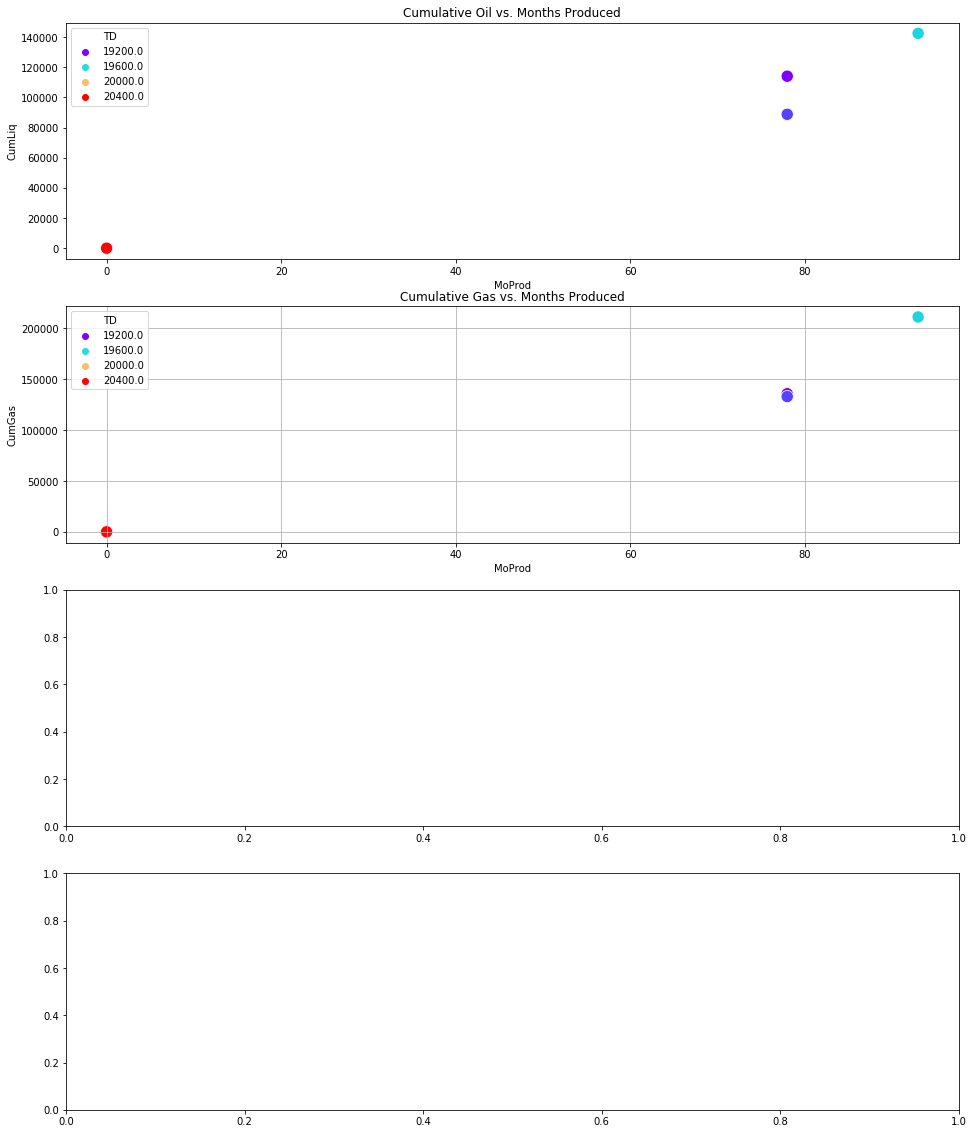

In [55]:
#Test Tract
a,b,c,d = getActivityData(16)

writeOldProdSummary(d, 16)
createOldProdDash(d,16)

In [ ]:
# #test loop

# perdashboard = []
# proddashboard = []
# leasedashboard = []

# for i in range(15,17):
    
#     tract = tractshp["tract_id"].iloc[i]
    
#     a, b, c, d = prepareTractFilter(tract)
    
#     perdashboard.append(createPermitDash(a,tract))
#     proddashboard.append(createProdDash(b, tract))
#     leasedashboard.append(createLeasesDash(c, tract))
    
    


## Running summary functions in loop to get summaries for all tracts

In [62]:
#creating empty array to append summaries to for each tract
summaryPermits = []
summaryProd = []
summaryLeases = []
summaryOldProd = []

#looping through each tract id and creating filtered geospatial data, activity summaries, and visualizaiton plots
for i in tractshp["tract_id"]:
    perm, prod, leases, oldprodtoeval = getActivityData(i) 
    
    try:
        summaryPermits.append(writePermitSummary(perm))
    except:
        summaryPermits.append("error occured")
        
    try:
        summaryProd.append(writeProdSummary(prod))
    except:
        summaryProd.append("error occured")
        
    try:
        summaryLeases.append(writeLeaseSummary(leases))
    except: 
        summaryLeases.append("error occured")

    try:
        summaryOldProd.append(writeOldProdSummary(oldprodtoeval, i))
    except: 
        summaryOldProd.append("error occured")

ValueError: min() arg is an empty sequence

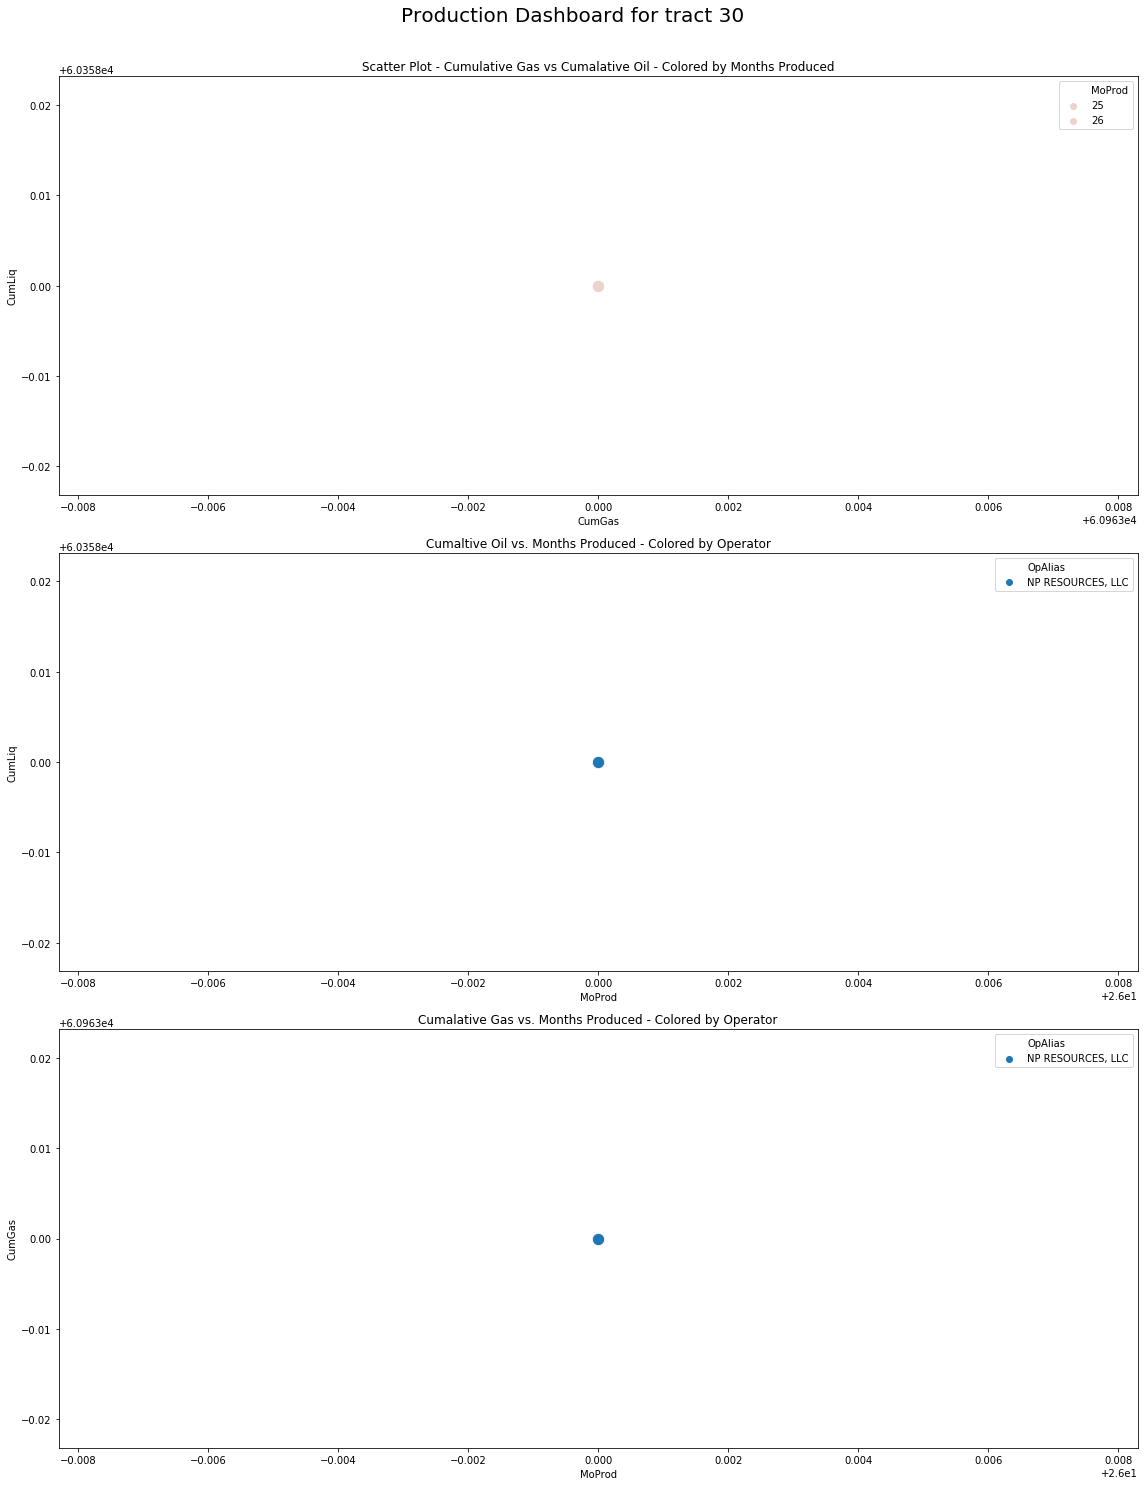

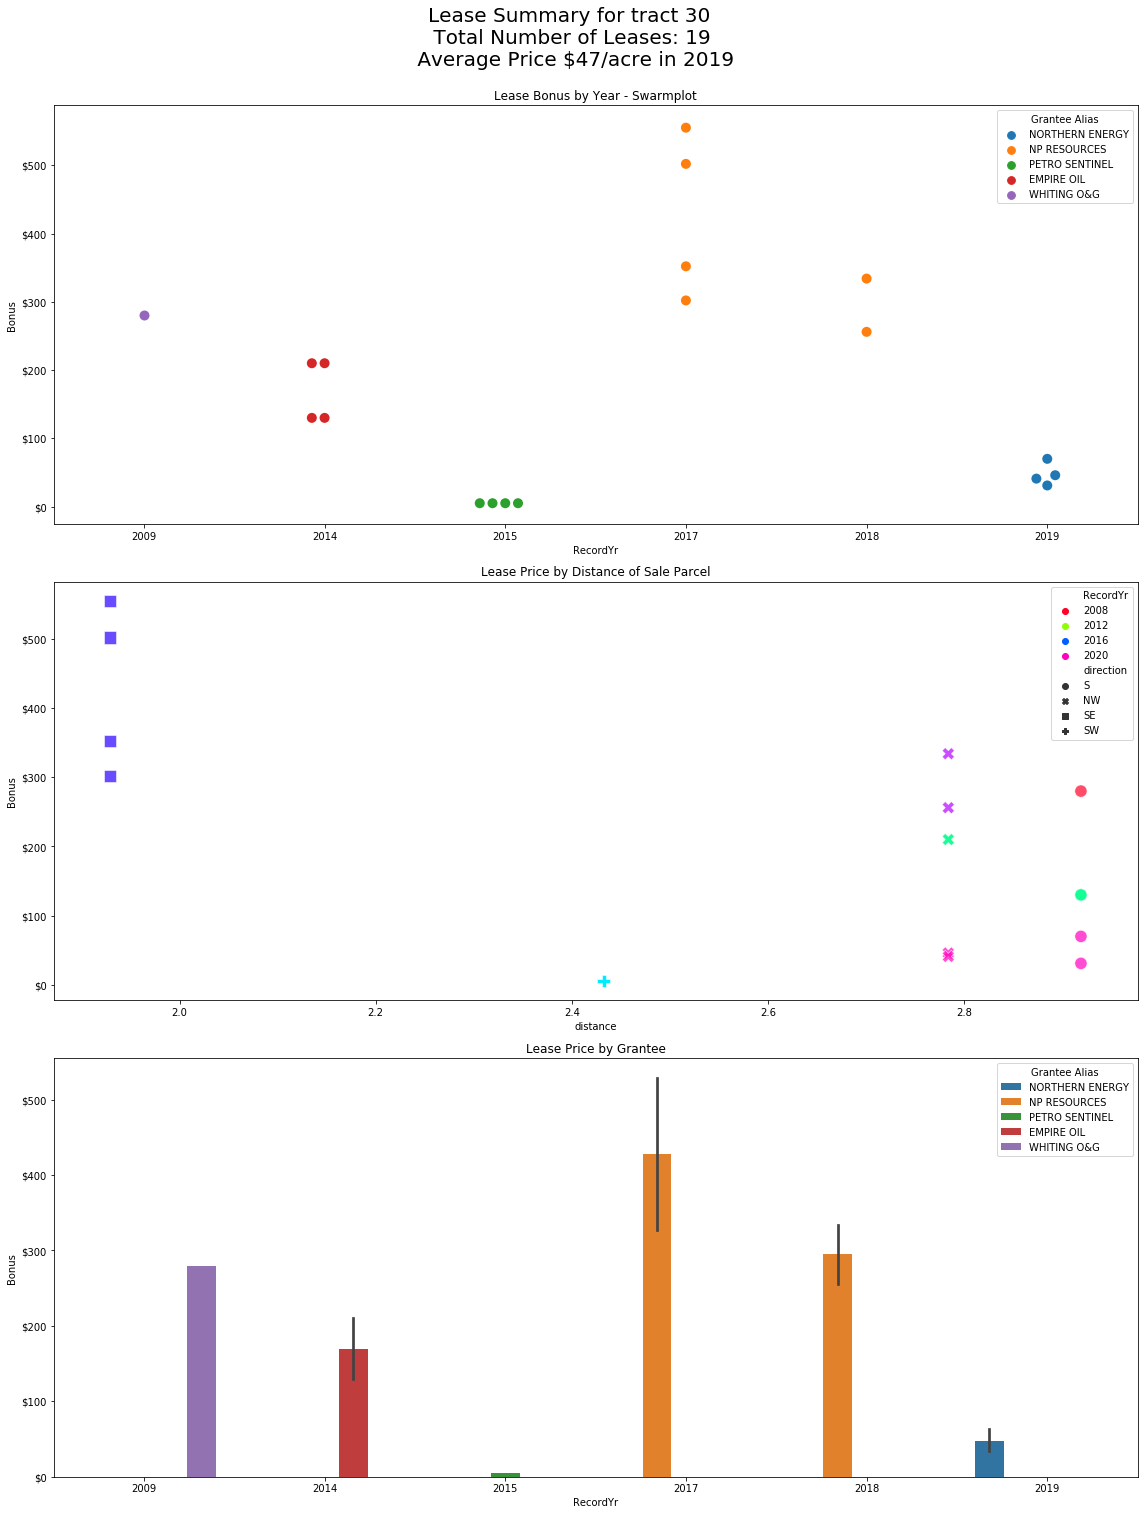

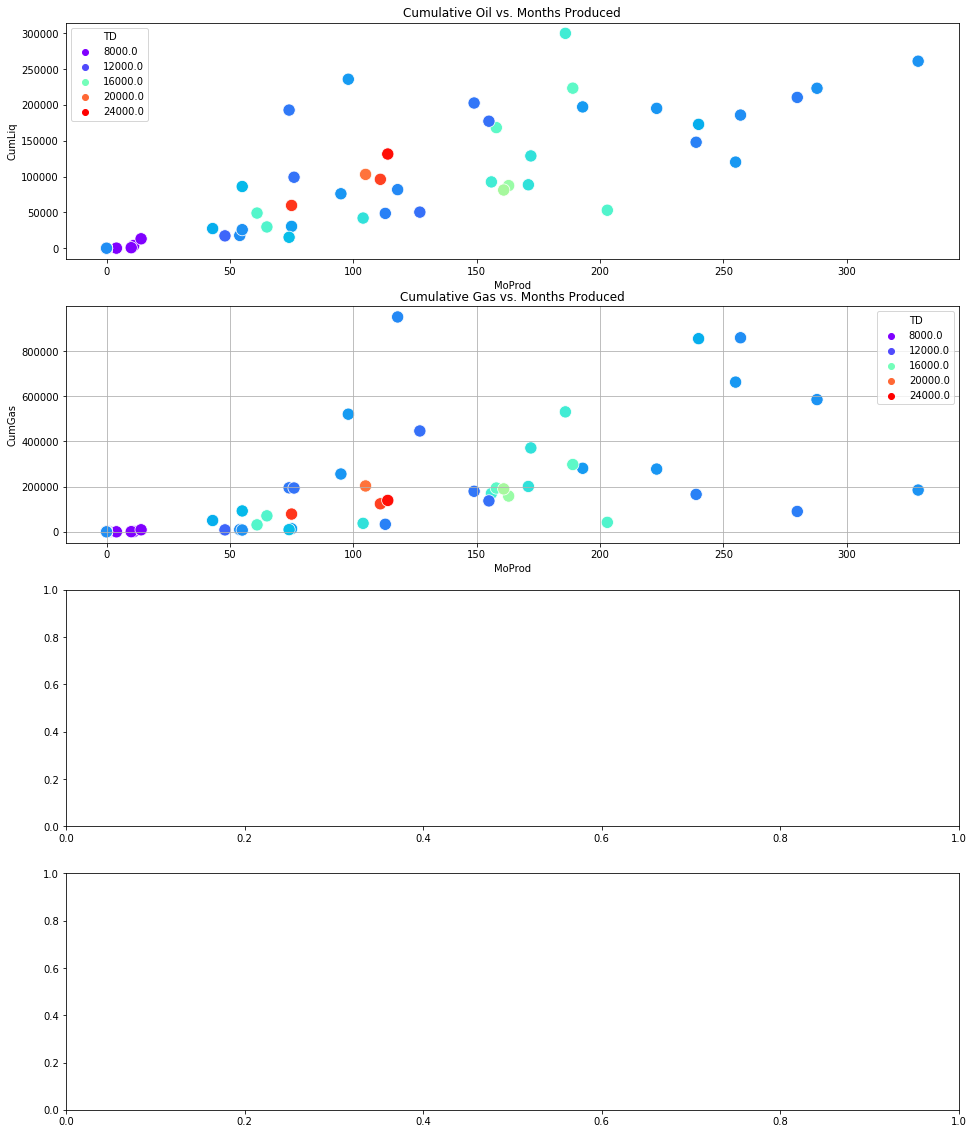

In [61]:


#creating arrays to append visual plots for each tract
perdashboard = []
proddashboard = []
leasedashboard = []
oldproddashboard = []

#looping through each tract id and creating filtered geospatial data, activity summaries, and visualizaiton plots
for i in tractshp["tract_id"]:
    perm, prod, leases, oldprodtoeval = getActivityData(i) 
    
    try:
        summaryPermits.append(writePermitSummary(perm))
    except:
        summaryPermits.append("error occured")
        
    try:
        summaryProd.append(writeProdSummary(prod))
    except:
        summaryProd.append("error occured")
        
    try:
        summaryLeases.append(writeLeaseSummary(leases))
    except: 
        summaryLeases.append("error occured")

    try:
        summaryOldProd.append(writeOldProdSummary(oldprodtoeval, i))
    except: 
        summaryOldProd.append("error occured")

    #appending visualizaiton plots to list    
    perdashboard.append(createPermitDash(perm,i))
    proddashboard.append(createProdDash(prod, i))
    leasedashboard.append(createLeasesDash(leases, i))  
    oldproddashboard.append(createOldProdDash(oldprodtoeval, i))
    

### Appending Results of mass loop of applying summary functions and visualization plots

In [63]:
#appending columns to tract list with summaries for each data type (old prod, leases, permits, new production)
tractshp["Permit Summary"] = summaryPermits

tractshp["Leases Summary"] = summaryLeases

tractshp["Old Production Summary"] = summaryOldProd

tractshp["Recent Prod Summary"] = summaryProd


In [64]:
tractshp

,lot_no,tract_id,Label,short_code,geometry,centroids,Acres,buffers,Permit Summary,Leases Summary,Old Production Summary,Recent Prod Summary
0,70254,30,ND-2020-09-0103,BLMMT-2020-Q3,"MULTIPOLYGON (((608548.856 5217534.425, 608358...",POINT (609229.253 5217346.041),37.0,"POLYGON ((614057.2727796743 5217346.041412733,...",There are no permits within a 3 mile radius,"In a 3 mile radius, the latest leases with bon...",There are no wells within tract boundaries \n\...,There are 1 wells within 3 mile radius that ha...
1,70248,24,ND-2020-09-0101,BLMMT-2020-Q3,"POLYGON ((626538.724 5163440.320, 626940.535 5...",POINT (626283.330 5162764.654),479.0,"POLYGON ((631111.3500722464 5162764.653754087,...",There are no permits within a 3 mile radius,"In a 3 mile radius, the latest leases with bon...",There are no wells within tract boundaries \n\...,There are no new wells in the last 4 years wit...
2,70257,33,ND-2020-09-0099,BLMMT-2020-Q3,"MULTIPOLYGON (((604156.364 5245709.308, 604231...",POINT (604244.402 5245041.610),614.0,"POLYGON ((609072.4217793554 5245041.610349718,...",There are no permits within a 3 mile radius,"In a 3 mile radius, the latest leases with bon...",There are 1 wells within the tract.\n1 wells d...,There are 1 wells within 3 mile radius that ha...
3,70240,16,ND-2020-09-0128,BLMMT-2020-Q3,"POLYGON ((620217.539 5385161.050, 620619.766 5...",POINT (620221.731 5384959.846),80.0,"POLYGON ((625049.7506576922 5384959.846286671,...",There are no permits within a 3 mile radius,"In a 3 mile radius, the latest leases with bon...",There are no wells within tract boundaries \n\...,There are 1 wells within 3 mile radius that ha...
4,70252,28,ND-2020-09-0105,BLMMT-2020-Q3,"POLYGON ((612010.339 5233325.177, 612018.435 5...",POINT (611600.308 5233717.666),320.0,"POLYGON ((616428.3282071579 5233717.665960711,...",There are no permits within a 3 mile radius,"In a 3 mile radius, the latest leases with bon...",There are 5 wells within the tract.\n5 wells r...,There are 1 wells within 3 mile radius that ha...
5,70246,22,ND-2020-09-0082,BLMMT-2020-Q3,"POLYGON ((622770.532 5277856.399, 622779.506 5...",POINT (622372.799 5277647.440),80.0,"POLYGON ((627200.8185002909 5277647.440071099,...",In a 3 mile radius there are 4 active permits\...,"In a 3 mile radius, the latest leases with bon...",There are no wells within tract boundaries \n\...,There are no new wells in the last 4 years wit...
6,70244,20,ND-2020-09-0120,BLMMT-2020-Q3,"POLYGON ((622956.513 5250983.956, 623358.155 5...",POINT (622972.985 5250181.045),319.0,"POLYGON ((627801.0049293509 5250181.045460863,...",In a 3 mile radius there are 2 active permits\...,error occured,There are 1 wells within the tract.\n1 wells r...,There are 1 wells within 3 mile radius that ha...
7,70255,31,ND-2020-09-0116,BLMMT-2020-Q3,"MULTIPOLYGON (((604392.549 5214269.497, 604384...",POINT (603343.656 5214231.610),359.0,"POLYGON ((608171.6757848245 5214231.610242323,...",There are no permits within a 3 mile radius,"In a 3 mile radius, the latest leases with bon...",There are no wells within tract boundaries \n\...,There are 1 wells within 3 mile radius that ha...
8,70256,32,ND-2020-09-0089,BLMMT-2020-Q3,"POLYGON ((604611.980 5247083.416, 605014.529 5...",POINT (604077.747 5247009.252),239.0,"POLYGON ((608905.7674401515 5247009.251608411,...",There are no permits within a 3 mile radius,"In a 3 mile radius, the latest leases with bon...",There are no wells within tract boundaries \n\...,There are 1 wells within 3 mile radius that ha...
9,70245,21,ND-2020-09-6777,BLMMT-2020-Q3,"POLYGON ((615774.053 5267269.349, 615784.551 5...",POINT (614906.072 5267386.851),278.0,"POLYGON ((619734.0917306377 5267386.851076917,...",There are no permits within a 3 mile radius,"In a 3 mile radius, the latest leases with bon...",There are no wells within tract boundaries \n\...,There are no new wells in the last 4 years wit...


### Writing Summary Results to File

In [65]:
#saving activity notes in an excel file in the results folder - dropping geopandas required geo cols
tractshp.drop(columns = "geometry centroids buffers".split(" ")).to_excel("Results/Activity Summary Notes.xlsx")

In [58]:
#zipping individual corresponding plots for each tract into one master list
MasterDash = list(zip(perdashboard, proddashboard, leasedashboard, oldproddashboard))

NameError: name 'perdashboard' is not defined

In [59]:
for item in MasterDash:
    for figures in item:
        figures

NameError: name 'MasterDash' is not defined

In [60]:
#saving visualizations in results subfolder called viz
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("Results/Permits Leases and Prod Visualizations.pdf")

#loooping through each set of figures for each tract, saving them to pdf
for items in MasterDash:
    for fig in items: 
        try:
            #bbox = tight is to make sure plot titles aren't cut off that have been shifted up
            pdf.savefig(fig, bbox_inches='tight')
        except:
            print("Error Occured - Most likely null figure")
        
pdf.close()


NameError: name 'MasterDash' is not defined